Kullanılan cihaz: cpu
⚠️ Bozuk/okunamayan görsel atlandı: data/archive/alziemer_dataset/train\Moderate Dementia\Moderate Dementia_original_64.jpg
Train görüntü sayısı: 11199
Val   görüntü sayısı: 2400
Test  görüntü sayısı: 2400
Sınıflar: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
EfficientNet-B0 Epoch 1/2 — Train: 0.8110  Val: 0.5845
EfficientNet-B0 Epoch 2/2 — Train: 0.4586  Val: 0.2985


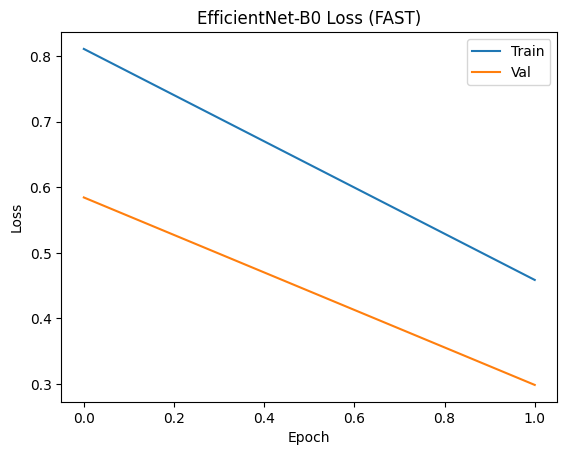


EfficientNet-B0 (FAST) SONUÇLAR
                    precision    recall  f1-score   support

     Mild Dementia       0.92      0.86      0.89       600
 Moderate Dementia       1.00      0.91      0.95       600
      Non Demented       0.92      0.91      0.92       600
Very mild Dementia       0.75      0.88      0.81       600

          accuracy                           0.89      2400
         macro avg       0.90      0.89      0.89      2400
      weighted avg       0.90      0.89      0.89      2400



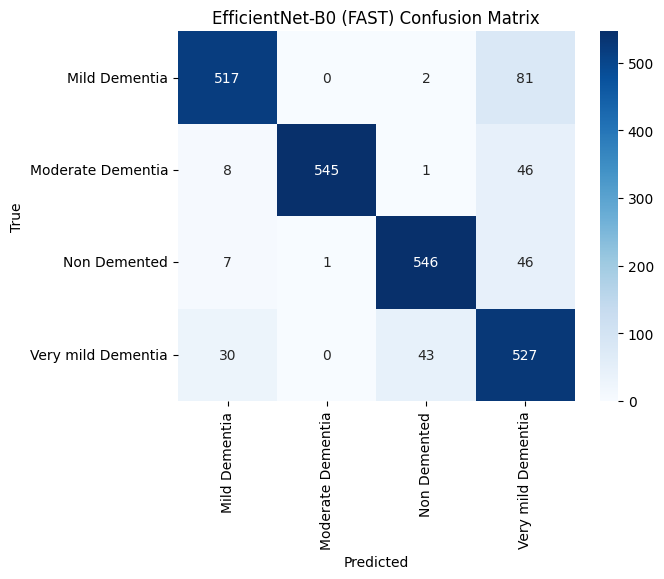

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to C:\Users\Hp/.cache\torch\hub\checkpoints\shufflenetv2_x1-5666bf0f80.pth
100%|█████████████████████████████████████████████████████████████████████████████| 8.79M/8.79M [00:07<00:00, 1.19MB/s]


ShuffleNetV2 Epoch 1/2 — Train: 1.2969  Val: 1.0769
ShuffleNetV2 Epoch 2/2 — Train: 1.0263  Val: 0.8096


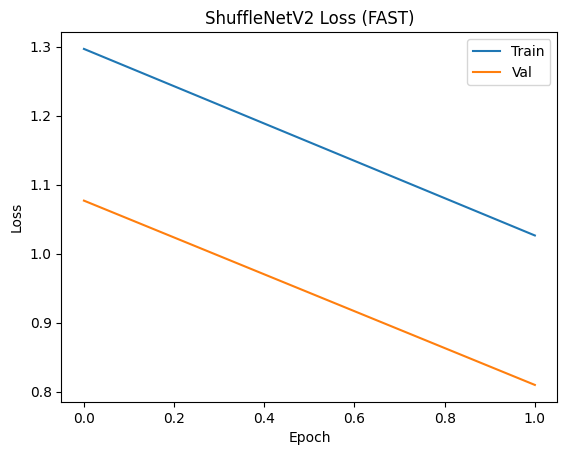

In [ ]:
########################################
# Hilal Boz — EfficientNet-B0 + ShuffleNetV2
# - Model 1: EfficientNet-B0 (transfer learning)
# - Model 2: ShuffleNetV2 
# - Cihaz: CPU / GPU otomatik
# - Bozuk görseller: otomatik atlanıyor
# - Hız için:
#     * 2 epoch
#     * Her epoch max 80 batch
########################################

import os
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import (
    efficientnet_b0, EfficientNet_B0_Weights,
    shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights
)
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ------------ CİHAZ SEÇİMİ ------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# ------------ DATA PATH (Kaggle 2D) ------------
train_dir = "data/archive/alziemer_dataset/train"
val_dir   = "data/archive/alziemer_dataset/val"
test_dir  = "data/archive/alziemer_dataset/test"

# ------------ TRANSFORM (2D) ------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

# ------------ BOZUK GÖRSELLERİ ATLAMA ------------
def is_valid_image(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except Exception:
        print("⚠️ Bozuk/okunamayan görsel atlandı:", path)
        return False

# ------------ DATASET & DATALOADER ------------
train_dataset = datasets.ImageFolder(train_dir, transform=transform, is_valid_file=is_valid_image)
val_dataset   = datasets.ImageFolder(val_dir,   transform=transform, is_valid_file=is_valid_image)
test_dataset  = datasets.ImageFolder(test_dir,  transform=transform, is_valid_file=is_valid_image)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, num_workers=0)

print("Train görüntü sayısı:", len(train_dataset))
print("Val   görüntü sayısı:", len(val_dataset))
print("Test  görüntü sayısı:", len(test_dataset))
print("Sınıflar:", train_dataset.classes)

num_classes = len(train_dataset.classes)

########################################
# EĞİTİM FONKSİYONU
########################################
def train_model_fast(model, name, epochs=2, lr=1e-4, max_batches=80):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []

    for e in range(epochs):
        # ---- TRAIN (kısmi dataset) ----
        model.train()
        total = 0.0
        batches = 0
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            loss = loss_fn(out,y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total += loss.item()
            batches += 1
            if batches >= max_batches:   # hız için sınırlama
                break

        train_losses.append(total / batches)

        # ---- VALIDATION (tam val set) ----
        model.eval()
        val_total = 0.0
        val_batches = 0
        with torch.no_grad():
            for x,y in val_loader:
                x = x.to(device)
                y = y.to(device)
                val_total += loss_fn(model(x),y).item()
                val_batches += 1
        val_losses.append(val_total / val_batches)

        print(f"{name} Epoch {e+1}/{epochs} — Train: {train_losses[-1]:.4f}  Val: {val_losses[-1]:.4f}")

    plt.figure()
    plt.plot(train_losses,label="Train")
    plt.plot(val_losses,label="Val")
    plt.title(name + " Loss (FAST)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model

########################################
# DEĞERLENDİRME FONKSİYONU
########################################
def evaluate(model, name):
    model = model.to(device)
    model.eval()
    preds, truths = [], []
    with torch.no_grad():
        for x,y in test_loader:
            x = x.to(device)
            out = model(x)
            preds.extend(torch.argmax(out,1).cpu())
            truths.extend(y)

    print(f"\n{name} SONUÇLAR")
    print(classification_report(truths, preds, target_names=train_dataset.classes))
    cm = confusion_matrix(truths, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.title(name + " Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# =====================================================
# MODEL 1 — EfficientNet-B0 (Transfer Learning)
# =====================================================

effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
in_features_eff = effnet.classifier[1].in_features
effnet.classifier[1] = nn.Linear(in_features_eff, num_classes)

effnet = train_model_fast(effnet, "EfficientNet-B0", epochs=2, lr=1e-4, max_batches=80)
torch.save(effnet.state_dict(), "member4_efficientnet_b0_fast.pth")

evaluate(effnet, "EfficientNet-B0 (FAST)")

# =====================================================
# MODEL 2 — ShuffleNetV2 (CNN)
# =====================================================

shufflenet = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
in_features_sh = shufflenet.fc.in_features
shufflenet.fc = nn.Linear(in_features_sh, num_classes)

shufflenet = train_model_fast(shufflenet, "ShuffleNetV2", epochs=2, lr=1e-4, max_batches=80)
torch.save(shufflenet.state_dict(), "member4_shufflenetv2_fast.pth")

evaluate(shufflenet, "ShuffleNetV2 (FAST)")
